## Import Useful Libraries

In [1]:
import tensorflow as tf
import cv2
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.contrib.layers import flatten
import pickle
# Visualizations will be shown in the notebook.
%matplotlib inline

## Function to Convert Images to GraySacle

In [2]:
# convert color images into grayscale images
def color_2_grayscale(image_data):
    gray_image_data = np.zeros(image_data.shape[:-1])
    #gray_image_data = np.zeros([len(image_data), image_data[0].shape[0], image_data[0].shape[1], 1])
    for i in range(len(image_data)):
        gray_image_data[i] = cv2.cvtColor(image_data[i],cv2.COLOR_RGB2GRAY)
    gray_image_data =  np.float32(gray_image_data)
    gray_image_data = gray_image_data.reshape(len(image_data),image_data[0].shape[0], image_data[0].shape[1], 1)
    return gray_image_data

#X_test = color_2_grayscale(X_test)
#print(X_test.shape)

## Function to Normalize Images

In [3]:
# normalize grayscale images between [-1, 1], to have 0 mean and unit standard deviation
def normalize_grayscale(image_data):
    img_min = 0
    img_max = 255
    new_min = -1
    new_max = 1
    x1 = (image_data - img_min) / (img_max - img_min)
    x2 = x1 * (new_max - new_min)
    x2 = x2 + new_min
    return x2

#X_test = normalize_grayscale(X_test)
#print(X_test.shape)

## Weight and Biases Variables

In [4]:
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.0008
n_classes = 43

mu = 0 # mean of weights
sigma = 0.1 # standard deviation of weights

W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mu, sigma), name = "W1")# [height, width, input_depth, output_depth]
W2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma), name = "W2") # [height, width, input_depth, output_depth]
W3 = tf.Variable(tf.truncated_normal([5*5*16, 120], mu, sigma), name = "W3") # [input_features, output_features]
W4 = tf.Variable(tf.truncated_normal([120, 84], mu, sigma), name = "W4") # [input_features, output_classes]
W5 = tf.Variable(tf.truncated_normal([84, n_classes], mu, sigma), name = "W5") # [input_features, output_classes]

b1 = tf.Variable(tf.zeros(6), name = "b1") # depth of convolution
b2 = tf.Variable(tf.zeros(16), name = "b2") # depth of convolution
b3 = tf.Variable(tf.zeros(120), name = "b3") # number of output features in fully connected layer
b4 = tf.Variable(tf.zeros(84), name = "b4") # number of classes in output layer           
b5 = tf.Variable(tf.zeros(n_classes), name = "b5") # number of classes in output layer                     

x = tf.placeholder(tf.float32, (None, 32, 32, 1)) 
y = tf.placeholder(tf.int32, (None))
dropout = tf.placeholder(tf.float32) 
one_hot_y = tf.one_hot(y, n_classes) 

## Modified LeNet

In [5]:
# define LeNet 
def Modified_LeNet(x, dropout):  
    global conv1, conv2, fc1, fc2, fc3
    strides = 1
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16, i.e., (H: (32 - 5 + 1)/1, W =(32 - 5 + 1)/1)
    conv1 = tf.nn.conv2d(x, W1, strides=[1, strides, strides, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, b1)
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    # TODO: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #print(conv1)
    # TODO: Layer 2: Convolutional Input = 14x14x16 Output = 10x10x32.
    conv2 = tf.nn.conv2d(conv1, W2, strides=[1, strides, strides, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, b2)
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #print(conv2)
    # TODO: Flatten. Input = 5x5x32. Output = 800.
    fc1 = tf.reshape(conv2, [-1, W3.get_shape().as_list()[0]])
    # TODO: Layer 3: Fully Connected. Input = 800. Output = 120.
    fc1 = tf.add(tf.matmul(fc1,W3), b3)
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1) 
    fc1 = tf.nn.dropout(fc1, dropout)
    #print(fc1)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, W4), b4)
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2) 
    fc2 = tf.nn.dropout(fc2, dropout)
    #print(fc2)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3 = tf.add(tf.matmul(fc2, W5), b5)
    #print(fc3)
    logits = fc3
    return logits


## Useful Functions to Predict the Labels and Evaluate Performance

In [6]:
# learning rate
beta = 0.0001
# we set up our training pipeline here to train the model
logits = Modified_LeNet(x, dropout) # pass the input data to LeNet() to calculate our logits
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits) # tf.nn.softmax_cross_entropy_with_logits() 
#function is used to compare those logits to the ground truth labels and caculate the cross entropy
# cross entropy is a measure of how different the logits are from the ground truth training labels

# Loss function using L2 Regularization
loss_operation = tf.reduce_mean(cross_entropy + beta * tf.nn.l2_loss(W1) + beta * tf.nn.l2_loss(W2) +
    beta * tf.nn.l2_loss(W3) + beta * tf.nn.l2_loss(W4) + beta * tf.nn.l2_loss(W5)) 
loss_operation1 = tf.reduce_mean(cross_entropy) 
# tf.reduce_mean() function is used calculate the average cross entropy from all the training images
optimizer = tf.train.AdamOptimizer(learning_rate = rate) # tf.train.AdamOptimizer() function is used to minimize the loss 
# function similarly to what stochastic gradient descent does. The Adam algorithm is a little more sophisticated than stochastic
# gradeient descent, so its a good defualt choice for an optimizer. This where we use learning rate hyper-parameter
training_operation = optimizer.minimize(loss_operation) # we run the minimize function on the optimizer which uses backpropagation
# to update the network and minimize our training loss

# measure whether a given prediction is correct by comparing the logit prediction ot the one-hot encoded ground truth label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# calculate the model's overall accuracy by averaging the individual prediciton accuracies
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# build evaluate functions to evaluate accuracy and loss
def evaluate(X_data, y_data, prob): # dataset as input
    num_examples = len(X_data) # number of samples in X_data
    total_accuracy = 0 
    total_loss = 0
    sess = tf.get_default_session()
    # batches the dataset and runs it through the evaluation pipeline for accuracy 
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation1, accuracy_operation], feed_dict={x: batch_x, y: batch_y, dropout: prob})
        total_accuracy += (accuracy * len(batch_x)) # add total accuracies for all the batches
        total_loss += (loss * len(batch_x))  # add total losses for all the batches
    accu = total_accuracy / num_examples
    los = total_loss / num_examples
    return los, accu  # returns the average accuracy and loss for the data set

## Load New Image

New Images Downloaded from Internet


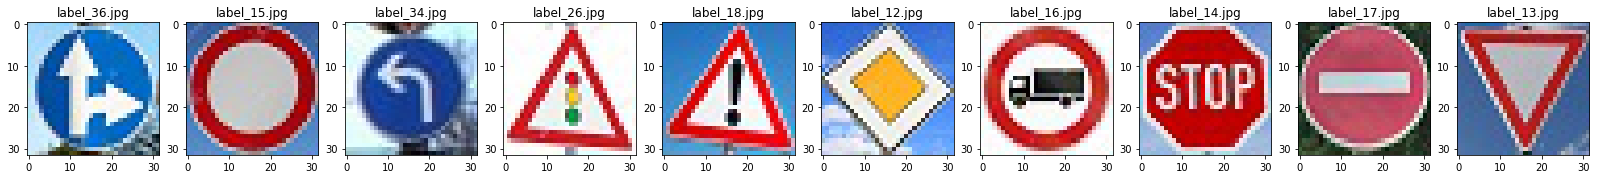

Grayscale New Images Downloaded from Internet


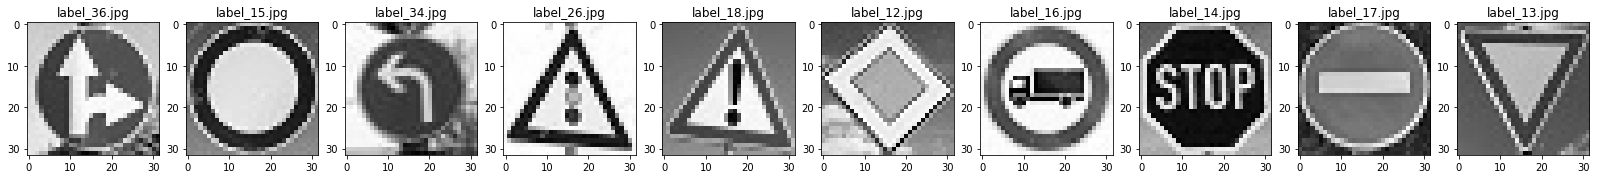

Normalized Grayscale New Images Downloaded from Internet


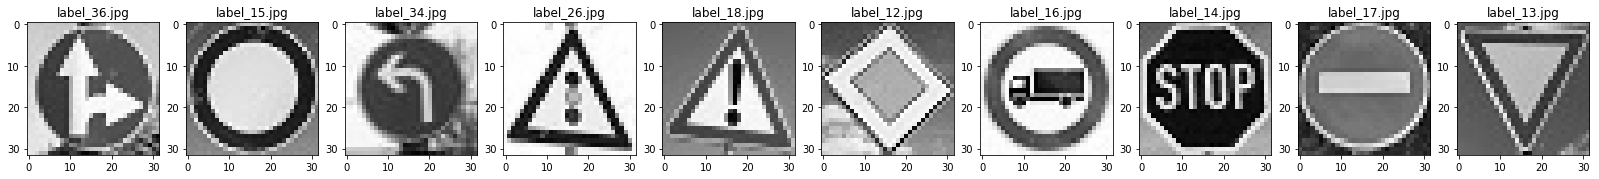

In [7]:
# Load the new images found on the internet
input = 'test_images/*.jpg'
name = glob.glob(input)
X_new = [ ]
y_new = [ ]
for image in name:  
    #print(image)
    img_name = image.split('_')[2] 
    label = img_name.split('.')[0] 
    y_new.append(np.uint8(label))
    img = mpimg.imread(image)
    X_new.append(img)

X_new = np.array(X_new)
y_new = np.array(y_new)

#squeeze()

# Plot the new images downloaded from the internet
print('New Images Downloaded from Internet')
fig = plt.figure(figsize=(28, 28))
for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.imshow(X_new[i])
    img_name = name[i].split('/')[1] 
    plt.title(img_name)

plt.show()

# Convert the new images to grayscale and plot them
X_new = color_2_grayscale(X_new)
print('Grayscale New Images Downloaded from Internet')
fig = plt.figure(figsize=(28, 28))
for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.imshow(X_new[i].squeeze(), cmap = 'gray')
    img_name = name[i].split('/')[1] 
    plt.title(img_name)

plt.show()

# Normalize the grayscale images and plot them
X_new = normalize_grayscale(X_new)
print('Normalized Grayscale New Images Downloaded from Internet')
fig = plt.figure(figsize=(28, 28))
for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.imshow(X_new[i].squeeze(), cmap = 'gray')
    img_name = name[i].split('/')[1] 
    plt.title(img_name)

plt.show()

## Predict the Label of New Images

In [8]:
save_file = './Modified_LeNet.ckpt'
with tf.Session() as sess:
    saver.restore(sess, save_file)
    labels = sess.run(logits, feed_dict={x: X_new, y: y_new, dropout: 1.0})

for i in range(10):
    print('Actual Label is', y_new[i], 'and Predicted Label is', np.argmax(labels[i]))

INFO:tensorflow:Restoring parameters from ./Modified_LeNet.ckpt
Actual Label is 36 and Predicted Label is 36
Actual Label is 15 and Predicted Label is 15
Actual Label is 34 and Predicted Label is 34
Actual Label is 26 and Predicted Label is 26
Actual Label is 18 and Predicted Label is 18
Actual Label is 12 and Predicted Label is 12
Actual Label is 16 and Predicted Label is 7
Actual Label is 14 and Predicted Label is 14
Actual Label is 17 and Predicted Label is 17
Actual Label is 13 and Predicted Label is 13


## Calculate Accuracy of Prediction

In [9]:
### Calculate the accuracy for new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, save_file)
    accuracy = sess.run(accuracy_operation, feed_dict={x: X_new, y: y_new, dropout: 1.0})

print('Accuracy of Prediction for New Images = {:.2f}'.format(accuracy*100))

INFO:tensorflow:Restoring parameters from ./Modified_LeNet.ckpt
Accuracy of Prediction for New Images = 90.00


## Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [10]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, save_file)
    labels = sess.run(logits, feed_dict={x: X_new, y: y_new, dropout: 1.0})
    top_five_prob = sess.run(tf.nn.top_k(tf.nn.softmax(labels), k=5))

np.set_printoptions(precision=2, suppress=True)
for i in range(top_five_prob[0].shape[0]):
    print('Top 5 Softmax Probabilies and their Labels for Image with Label', y_new[i])
    print(top_five_prob[0][i] * 100)
    print(top_five_prob[1][i])
    print()

INFO:tensorflow:Restoring parameters from ./Modified_LeNet.ckpt
Top 5 Softmax Probabilies and their Labels for Image with Label 36
[100.   0.   0.   0.   0.]
[36 38 32 41 13]

Top 5 Softmax Probabilies and their Labels for Image with Label 15
[ 99.91   0.06   0.02   0.01   0.  ]
[15 17 12  9 13]

Top 5 Softmax Probabilies and their Labels for Image with Label 34
[ 100.    0.    0.    0.    0.]
[34 35 14 38 30]

Top 5 Softmax Probabilies and their Labels for Image with Label 26
[ 100.    0.    0.    0.    0.]
[26 18 24 25  4]

Top 5 Softmax Probabilies and their Labels for Image with Label 18
[ 100.    0.    0.    0.    0.]
[18 26 25 24 22]

Top 5 Softmax Probabilies and their Labels for Image with Label 12
[ 100.    0.    0.    0.    0.]
[12 13  7 40 38]

Top 5 Softmax Probabilies and their Labels for Image with Label 16
[ 80.26  16.49   3.25   0.     0.  ]
[ 7  5 16 42 10]

Top 5 Softmax Probabilies and their Labels for Image with Label 14
[ 91.17   5.34   2.51   0.6    0.16]
[14  2 3

In [11]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./Modified_LeNet.ckpt


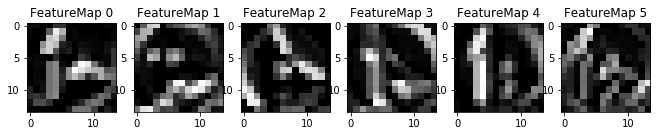

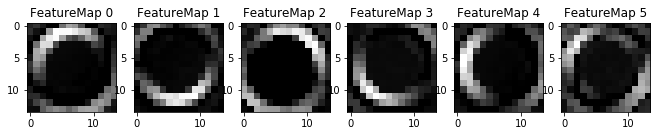

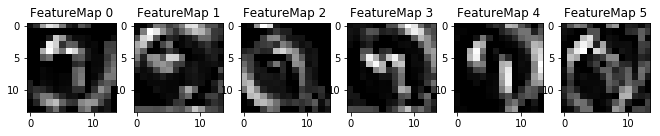

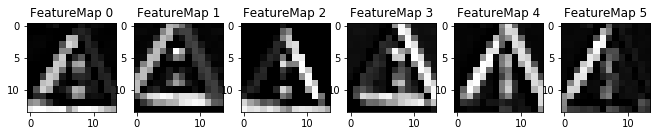

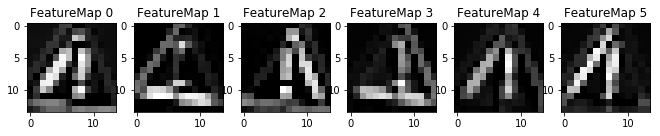

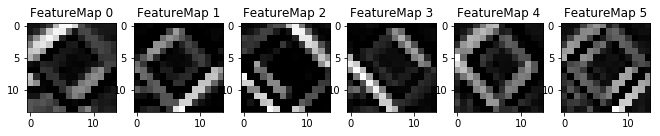

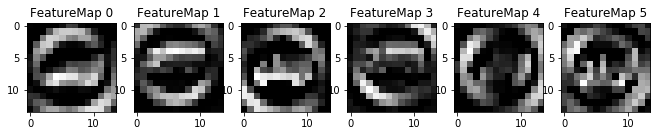

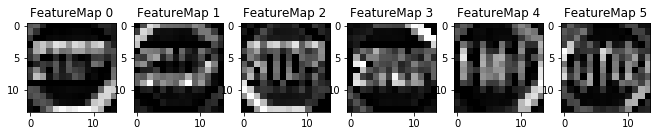

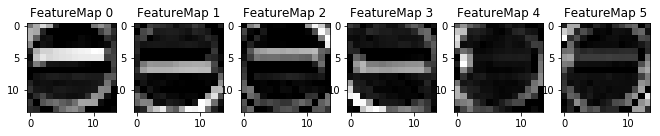

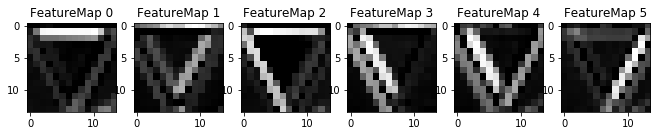

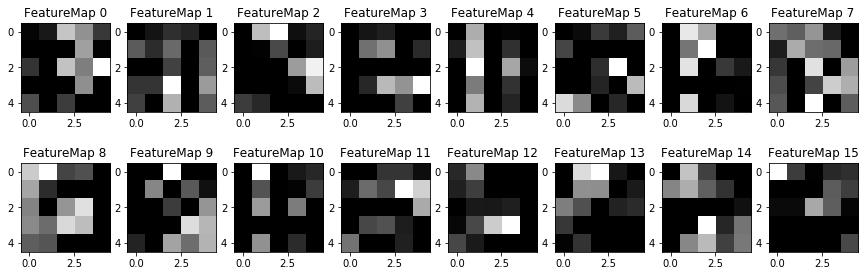

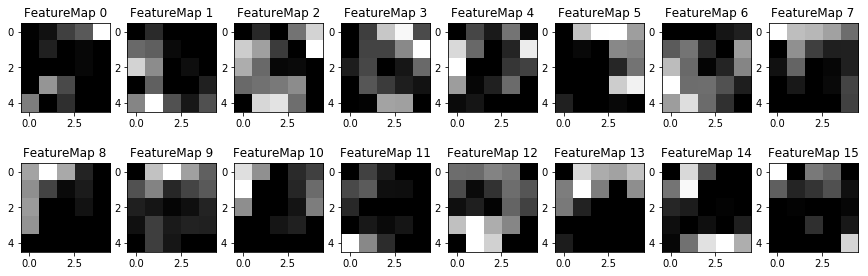

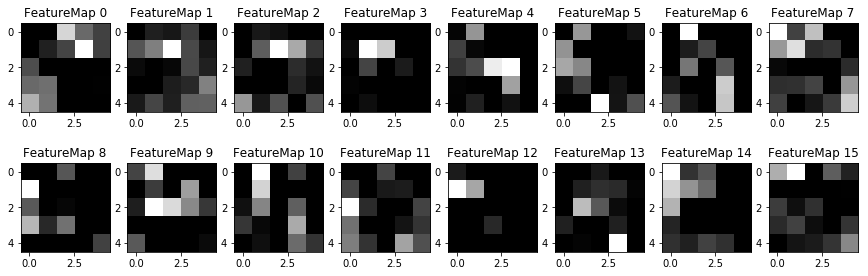

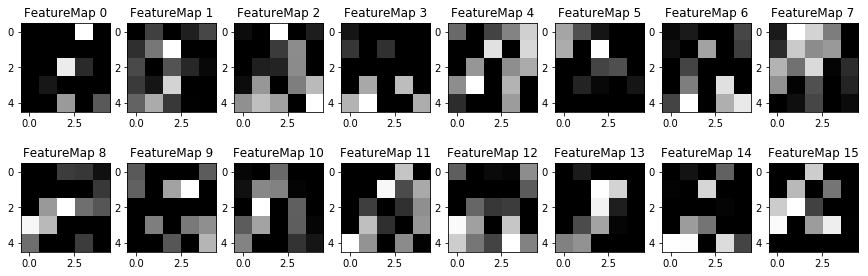

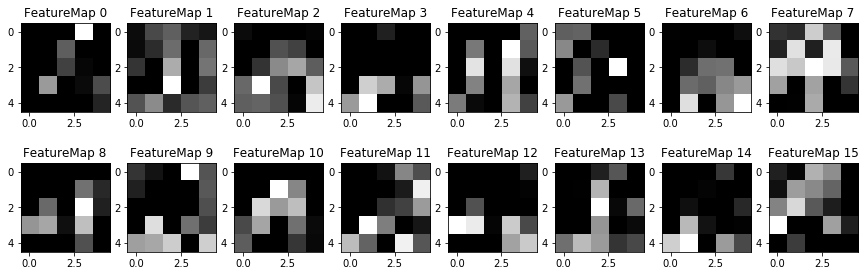

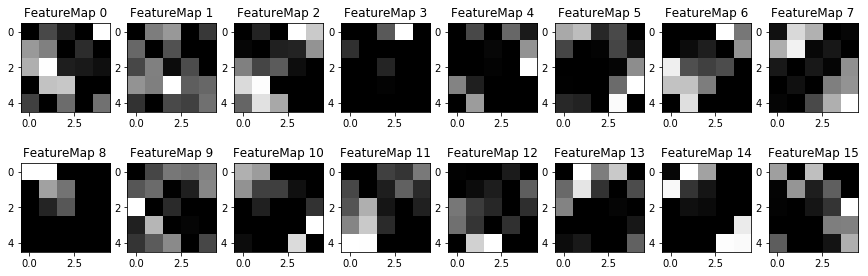

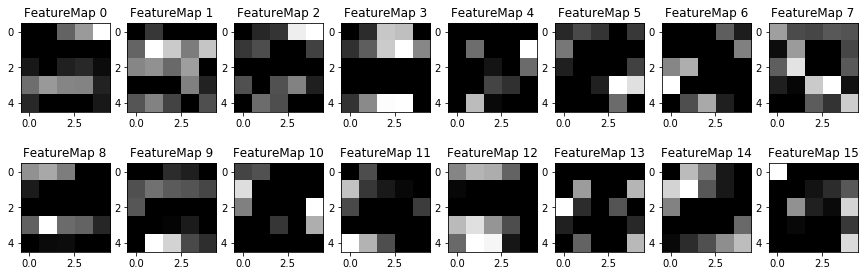

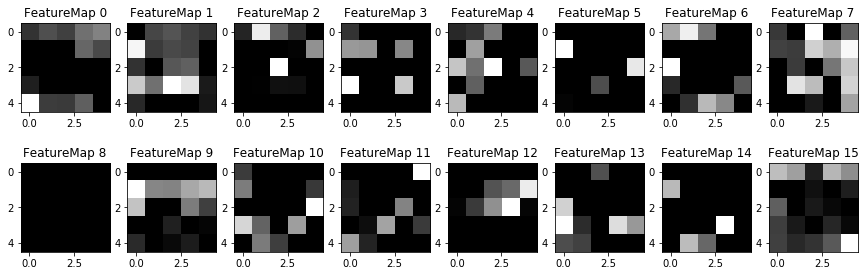

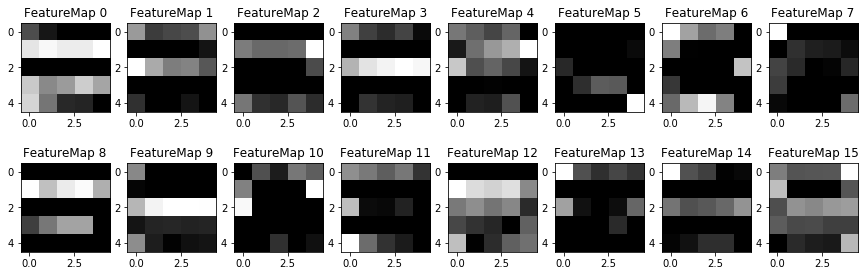

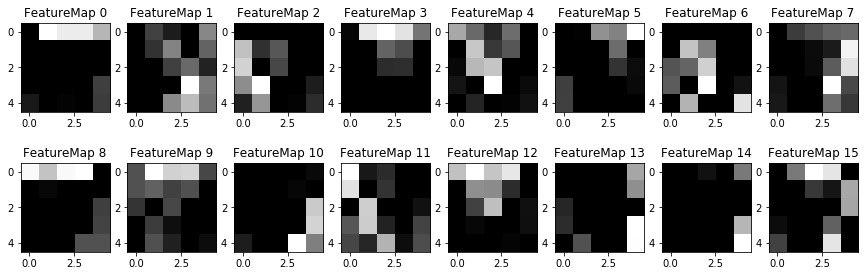

In [34]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    for i in range(10):
        img = X_new[i].reshape(1,32,32,1)
        outputFeatureMap(img, conv1, activation_min=-1, activation_max=-1 ,plt_num=1)
        plt.show()
    for i in range(10):
        img = X_new[i].reshape(1,32,32,1)
        outputFeatureMap(img, conv2, activation_min=-1, activation_max=-1 ,plt_num=1)
        plt.show()